# Новые приключения
С новыми силами приступаем к обработке. Мои прошлые приключения и заключения можно найти в ноутбуке `research_callcenter`, там я не добился больших результатов, но нашёл интересные инсайты в данных.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import stats
from analisis_utils import *

In [75]:
data = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')
webstat = pd.read_csv('t1_webstat.csv', sep=',')
webstat.sort_values('date_time', inplace=True)
webstat.date_time = pd.to_datetime(webstat.date_time, errors='raise')
data.create_time = pd.to_datetime(data.create_time, errors='raise')
test.create_time = pd.to_datetime(test.create_time, errors='raise')

In [45]:
webstat.head(15)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN
2268626,109996122,1975-10-17 13:44:14.300,2,6,12.0,7418.0,NaN,NaN,NaN,NaN
2267446,109996122,1975-10-17 13:44:26.633,2,7,NaN,7419.0,NaN,NaN,NaN,NaN
2268627,110019268,1975-10-17 15:25:56.300,7,1,122.0,NaN,NaN,NaN,NaN,NaN
2268628,110019268,1975-10-17 15:27:58.257,1,2,43.0,206.0,8748965.0,22312252.0,2986.0,1.0
2269207,110019268,1975-10-17 15:28:41.860,7,3,NaN,NaN,NaN,NaN,NaN,NaN


Здесть происходит агрегирование данных из `webstat`

In [59]:
session_agg = webstat.groupby('sessionkey_id', sort=False).agg(
    ses_duration=('date_time', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
    page_type_mode=('page_type', lambda x: x.mode().iloc[0]),
    pageview_duration_sec_max=('pageview_duration_sec', lambda x: x.max()),
    pageview_duration_sec_mean=('pageview_duration_sec', lambda x: x.mean()),
    nan_counter=('product_in_sale', lambda x: x.isna().sum()),
    price_mean=('price', np.nanmean),
    ses_counter=('date_time', lambda x: x.count()),
    page_type_counter=('page_type', lambda x: x.nunique()),
    date_time_hour=('date_time', lambda x: x.dt.hour.mean()),
    date_time_mean=('date_time', lambda x: x.mean()),
)
session_agg

,ses_duration,page_type_mode,pageview_duration_sec_max,pageview_duration_sec_mean,nan_counter,price_mean,ses_counter,page_type_counter,date_time_hour,date_time_mean
sessionkey_id,,,,,,,,,,
109996122,89.680,2,25.0,15.000000,7,NaN,7,1,13.0,1975-10-17 13:43:44.830857152
110019268,165.560,7,122.0,82.500000,2,2986.0,3,2,15.0,1975-10-17 15:27:32.139000000
110020180,0.000,1,NaN,NaN,0,4490.0,1,1,15.0,1975-10-17 15:29:52.147000000
110040418,591.490,2,281.0,54.500000,7,578.0,11,4,17.0,1975-10-17 17:09:06.976636352
110044482,0.000,1,NaN,NaN,0,4490.0,1,1,17.0,1975-10-17 17:27:55.297000000
...,...,...,...,...,...,...,...,...,...,...
134626779,0.000,3,22.0,22.000000,1,NaN,1,1,20.0,1976-02-16 20:47:13.283000000
134627402,298.784,6,109.0,40.666667,6,411.0,7,3,20.0,1976-02-16 20:53:28.422857152
134628420,273.624,3,45.0,23.250000,5,NaN,5,4,20.0,1976-02-16 20:56:15.736800000


In [70]:
X = data.merge(session_agg, how='left', on='sessionkey_id', sort=False)
X['diff_time'] = X.create_time - X.date_time_mean
X['diff_time'] = X.diff_time.dt.total_seconds()
X.drop(['create_time', 'model_create_time', 'date_time_mean', 'is_moderated', 'root_id', 'rating_value'], axis=1, inplace=True)
X.head()

,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,model_id,rating_count,...,ses_duration,page_type_mode,pageview_duration_sec_max,pageview_duration_sec_mean,nan_counter,price_mean,ses_counter,page_type_counter,date_time_hour,diff_time
0,1269921,9896348,753,5,8.0,123777004,139,133,123517,6.0,...,0.000,1.0,NaN,NaN,0.0,753.000000,1.0,1.0,9.000000,544.607000
1,1270034,9896348,753,1,2.0,123781654,139,133,123517,6.0,...,4236.550,1.0,1060.0,141.888889,16.0,984.666667,28.0,6.0,10.000000,-227.555393
2,1268272,9896348,753,2,3.0,123591002,139,133,123517,6.0,...,369.577,1.0,256.0,61.666667,5.0,753.000000,7.0,5.0,11.000000,296.228429
3,1270544,9896348,753,1,1.0,123832302,139,133,123517,6.0,...,1925.996,2.0,1402.0,385.200000,6.0,NaN,6.0,1.0,13.666667,282.945000
4,1270970,9896348,753,3,56.0,123881603,139,133,123517,6.0,...,446.287,3.0,42.0,15.666667,5.0,753.000000,6.0,4.0,18.000000,462.842000


# LightGBM 1

In [71]:
X_train, X_val, y_train, y_val = train_test_split(X.drop(['is_callcenter'], axis=1),
                                                  data['is_callcenter'],
                                                  test_size=0.20,
                                                  random_state=42)

In [72]:
X.columns

Index(['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'model_id', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty', 'is_callcenter',
       'ses_duration', 'page_type_mode', 'pageview_duration_sec_max',
       'pageview_duration_sec_mean', 'nan_counter', 'price_mean',
       'ses_counter', 'page_type_counter', 'date_time_hour', 'diff_time'],
      dtype='object')

In [115]:
cat_cols = ['utm_medium', 'category_id', 'parent_id',]
lgb_tr = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)

params_lgb = {
    'objective': 'binary', 
    'eta': 0.1,
    'max_leaves': 2**9,
    'metric': ['auc', ''],
    'seed': 42,
    'num_threads': 32,
    'verbosity': 1,
    'is_unbalance': True
}

model_lgb = lgb.train(
    params_lgb, lgb_tr, num_boost_round=100, # basic
    valid_sets=[lgb_val], valid_names=['валидация'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=3, min_delta=0.),
        lgb.log_evaluation(period=5) # чтобы выводились результаты подсчета метрики для early_stopping
   ] 
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 29704, number of negative: 53972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5176
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354988 -> initscore=-0.597184
[LightGBM] [Info] Start training from score -0.597184
Training until validation scores don't improve for 3 rounds
[5]	валидация's auc: 0.884792
[10]	валидация's auc: 0.888591
[15]	валидация's auc: 0.889823
[20]	валидация's auc: 0.891829
[25]	валидация's auc: 0.893888
[30]	валидация's auc: 0.896184
[35]	валидация's auc: 0.89751


In [127]:
y_lgb1_pred =model_lgb.predict(X_val)
roc_auc_score(y_val, y_lgb1_pred)

0.9035557551356375

Как мы видим, новые признаки дают довольно большой вклад в предсказание. В дальнейшем я попробую развить эту идею

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

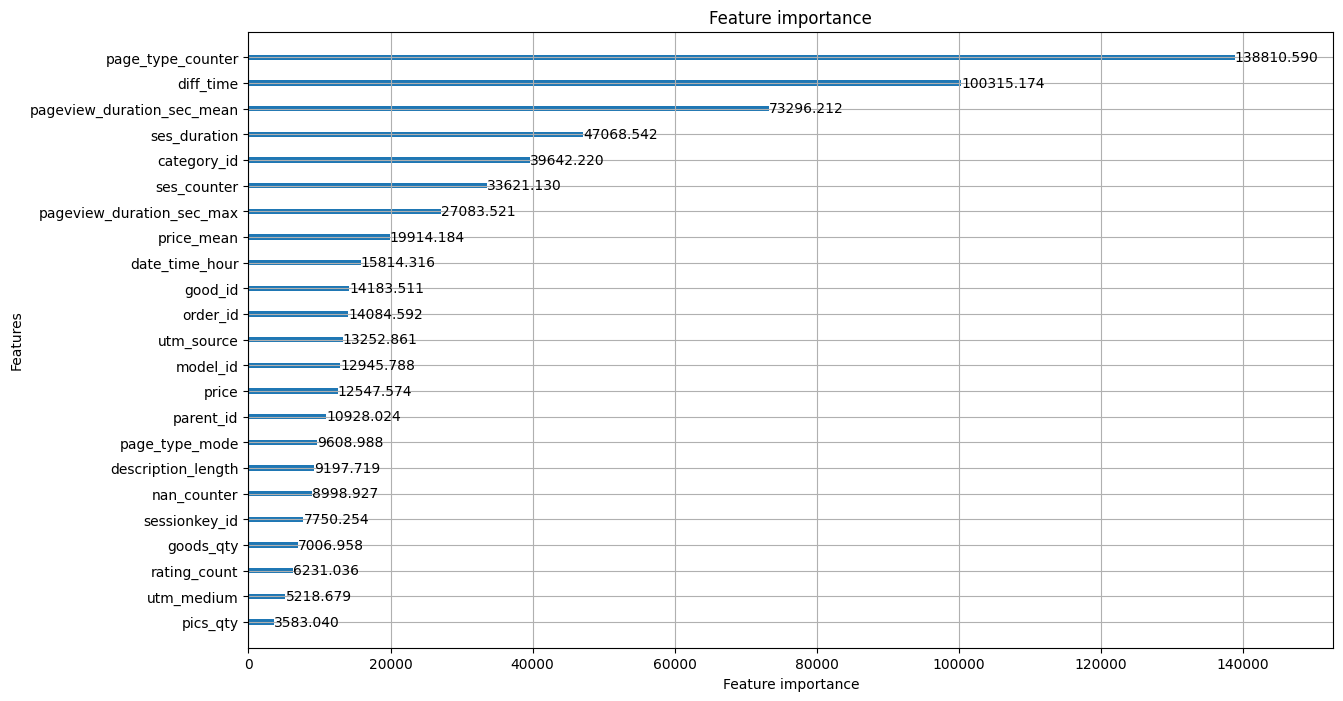

In [113]:
lgb.plot_importance(model_lgb, importance_type='gain', figsize=(14, 8), max_num_features=30)

In [76]:
Y = test.merge(session_agg, how='left', on='sessionkey_id', sort=False)
Y['diff_time'] = Y.create_time - Y.date_time_mean
Y['diff_time'] = Y.diff_time.dt.total_seconds()
Y.drop(['create_time', 'model_create_time', 'date_time_mean', 'is_moderated', 'root_id', 'rating_value'], axis=1, inplace=True)

In [79]:
y_summit = model_lgb.predict(Y)

submit1 = pd.DataFrame({
    'order_id' : test['order_id'],
    'is_callcenter' : y_summit
})
submit1.to_csv('submit1.csv', sep=',', index=False)

Какой же молодец, побил бейслайн!!! Теперь пора в лигу чемпионов \
На самом деле я немного в шоке от того, что делая практически тоже самое, я не мог добиться того же результата. Но опять же я делал акцент на `train`

# CatBoost 1
В предыдущих приключениях я ставил довольно большой акцент на `train`. Там довольно много категориальных данных. Давайте же посмотрим, как CatBoost сможет переварить эту задачу

In [81]:
X.columns

Index(['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'model_id', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty', 'is_callcenter',
       'ses_duration', 'page_type_mode', 'pageview_duration_sec_max',
       'pageview_duration_sec_mean', 'nan_counter', 'price_mean',
       'ses_counter', 'page_type_counter', 'date_time_hour', 'diff_time'],
      dtype='object')

In [110]:
# Тут я постараюсь все категориальные фитчи засунуть в список
cat_features = ['utm_medium', 'category_id', 'parent_id', 'good_id', 'model_id',]

params_cb = {
    'objective': 'Logloss',
    'eta' : 0.1,
    'depth': 5,
    'score_function': 'L2',
    'iterations': 1000,
    'early_stopping_rounds': 5,
    'od_type': 'Iter',
    'verbose': False,
    'random_seed': 42,
    'has_time' : False,
    'eval_metric' : 'AUC',
}
model_cb = cb.CatBoostClassifier(**params_cb)
model_cb.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=(X_val, y_val),
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [125]:
roc_auc_score(y_val, model_cb.predict_proba(X_val)[:,1])

0.9096007818419722

`CatBoost` тоже умничка, набрал скор чуть больше чем `LightGBM`

# Логистическая регрессия
В предыдущих странствиях она дала неплохие результаты, поэтому давате попробуем посмотреть, что будет в этот раз. Если результаты будут хорошими, то воспользуемся ею для ансамбля.

In [128]:
from sklearn.linear_model import LogisticRegression

log_reg1 = LogisticRegression(penalty='l1', max_iter=100, solver='liblinear', tol=1e-4)
log_reg1.fit(X_train.fillna(X_train.mean()), y_train)

log_reg2 = LogisticRegression(penalty='l2', max_iter=100, solver='liblinear', tol=1e-4)
log_reg2.fit(X_train.fillna(X_train.mean()), y_train)

y_logregl1_pred = log_reg1.predict_proba(X_val.fillna(X_train.mean()))[:,1]
print(roc_auc_score(y_val, y_logregl1_pred))
y_logregl2_pred = log_reg2.predict_proba(X_val.fillna(X_train.mean()))[:,1]
print(roc_auc_score(y_val, y_logregl2_pred))

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7997832116354788
0.5204477993096288


Получили довольно неплохой результат и интресеную деталь, что `l1` показало себя лучше чем `l2`

# Кластеризация
Не даром я проводил исследование нашего датасета. Я точно знаю, что в `train` и `test` есть `sessionkey_id`, которых нет в `webstat`. Это значит, что предсказания на этих семплах проходят как попало. Давайте же попробуем найти наиболее похожий результат на такой случай.

In [92]:
# Пример проблемы
X[X['nan_counter'].isna()]

,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,model_id,rating_count,...,ses_duration,page_type_mode,pageview_duration_sec_max,pageview_duration_sec_mean,nan_counter,price_mean,ses_counter,page_type_counter,date_time_hour,diff_time
154,1287030,67142321,1561,3,12.0,125592233,155,154,124328,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
864,1169533,63404371,1338,5,8.0,113969090,1200,5674,131210,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,1208051,5364697,2357,3,6.0,117433285,170,169,125540,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1455,1327152,9896348,889,2,NaN,130361576,139,133,123517,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1495,1251675,68140757,844,2,NaN,116497085,155,154,124319,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104448,1233896,65304908,10806,5,47.0,120130598,3988,202,37222412,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104467,1229646,36747613,656,3,21.0,119598230,1214,1213,35584198,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104531,1189773,20276482,2545,2,3.0,115843722,2360,1634,35897484,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104554,1276214,57998993,1271,6,4.0,124503145,196,184,37645965,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Да, по итогу мы сможем улучшить предсказания для 155 семплов, т.е улучшить ~1% предсказаний!
Y[Y['nan_counter'].isna()]

,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,model_id,rating_count,...,ses_duration,page_type_mode,pageview_duration_sec_max,pageview_duration_sec_mean,nan_counter,price_mean,ses_counter,page_type_counter,date_time_hour,diff_time
158,1363645,28597927,4414,3,5.0,133798224,127,125,123478,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,1367176,23243906,2541,3,5.0,133960562,1259,5675,135959,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,1343288,62972443,885,3,5.0,132064096,1468,238,131540,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698,1367234,39217066,701,1,14.0,133966333,1259,5675,135964,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
934,1364420,19569719,2513,3,6.0,133837090,2449,1212,145737,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16701,1342481,21862764,1589,3,6.0,132014498,1200,5674,34309042,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16838,1351056,74268594,620,2,NaN,132744970,7680,7270,34149887,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16910,1364546,74223410,971,6,4.0,133044733,3688,5604,35265216,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17057,1367008,77355099,95,3,5.0,133959111,1271,1254,35886588,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
Y.columns

Index(['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'model_id', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty', 'ses_duration',
       'page_type_mode', 'pageview_duration_sec_max',
       'pageview_duration_sec_mean', 'nan_counter', 'price_mean',
       'ses_counter', 'page_type_counter', 'date_time_hour', 'diff_time'],
      dtype='object')

In [136]:
from sklearn.neighbors import NearestNeighbors
k = 1 # ищем одного близжайшего соседа

# в поиске соседа мы будем ориентироваться на первые 13 признаков
# xb - это то, на чём мы обучаем

xb = X[X.ses_counter.notna()][['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'model_id', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty']]

# те значения из Х и Y, к которым мы хотим соседа
xq = X[X.ses_counter.isna()][['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'model_id', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty']]

yq = Y[Y.ses_counter.isna()][['order_id', 'good_id', 'price', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id', 'parent_id', 'model_id', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty']]

xb = xb.fillna(xb.mean()).to_numpy()
xq = xq.fillna(xq.mean()).to_numpy()
yq = yq.fillna(yq.mean()).to_numpy()

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(xb)

distance_x, index_x = neigh.kneighbors(xq)
distance_y, index_y = neigh.kneighbors(yq)

In [139]:
for ind in index_x:
    same_ord_id = xb[ind, 0]
    

array([8038], dtype=int64)

В общем не успел сделать всё, что хотел